In [2]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

In [3]:
list_of_fit_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" in v]

In [4]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet(".\\data\\fit_file_laps.parquet")
fit_file_points = pd.read_parquet(".\\data\\fit_file_points.parquet")

In [5]:
def compute_power(weight, bike_wgt, speed, slope):
    
    # 1) rolling resistance
    C_rr = np.random.uniform(0.0025, 0.005) # coefficient of rolling resistance
    m = weight + bike_wgt # total mass
    g = 9.81

    P_rr = C_rr * m * speed * g

    # 2) Aerodynamic drag
    rho = 1.225 # air density
    C_d = 0.88 # drag coefficient
    A = 0.5 # frontal area

    P_aero = 0.5 * rho * C_d * A * np.power(speed, 3)

    # 3) Gradient resistance
    slope_rad = slope * (np.pi/180)
    P_gr = m * g * speed * np.sin(slope_rad)

    eta = 0.95 # drivetrain efficiency

    P = (P_rr + P_aero + P_gr) / eta

    return max(np.divide(P, weight), 0)

In [6]:
def ReLU(x):
    return x * (x > 0)

1. Prendi attività Zwift:
     * y = errore (power_stimata, power_reale)
     * power_stimata con grade = 0
     * X = pesi, speed, cadence, grade
     * Come cambia l'errore in base a X
2. Prendi i coefficienti ottenuti in (1) con attività Garmin
    * y = power_stimata + $\alpha\cdot$ speed + $\beta\cdot$ HR
    * ricalcola errore rispetto a potenza media da Strava

In [7]:
_, dr = parse_fit.get_dataframes(".\\data\\DR\\16438299806_ACTIVITY.fit")

In [8]:
from sklearn import tree
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import plot_model
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.python.framework.random_seed import set_random_seed

In [9]:
Xy = dr[["altitude", "cadence", "enhanced_speed", "current_slope", "heart_rate", "power"]].copy()
Xy["heart_rate"] = Xy["heart_rate"].bfill()
Xy["current_slope"] = Xy["current_slope"].fillna(0)
Xy.loc[(Xy["cadence"].isnull()) & (Xy["enhanced_speed"] == 0), "cadence"] = 0
Xy["power"] = Xy["power"].fillna(0)
Xy["power"] = Xy["power"]/85.5

# Xy["athlete_weight"] = 85.5
# Xy["bike_weight"] = 8.8

Xy = Xy.dropna(how = "any").reset_index(drop = True)

Xy["estimated_power"] = Xy.apply(lambda row: compute_power(weight = 85.5, bike_wgt = 8.8,
                                                           speed = row["enhanced_speed"],
                                                           slope = row["current_slope"]),
                                 axis = 1)

X = Xy.drop("power", axis = 1)
y = Xy["power"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

RMSE: 1.97
MAE: 1.33


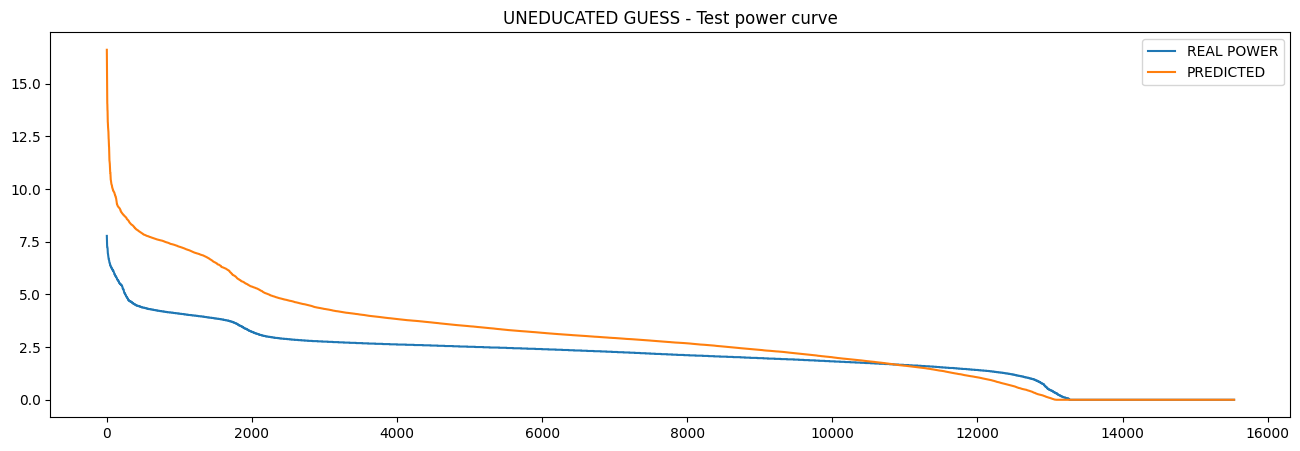

In [10]:
# Uneducated guess
print("RMSE: {:.2f}".format(mean_squared_error(y_train, X_train["estimated_power"], squared=False)))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, X_train["estimated_power"])))

plt.figure(figsize = (16, 5))
plt.plot(sorted(y)[::-1], label = "REAL POWER")
plt.plot(sorted(Xy["estimated_power"])[::-1], label = "PREDICTED")
plt.title("UNEDUCATED GUESS - Test power curve")
plt.legend()
plt.show()

<Axes: >

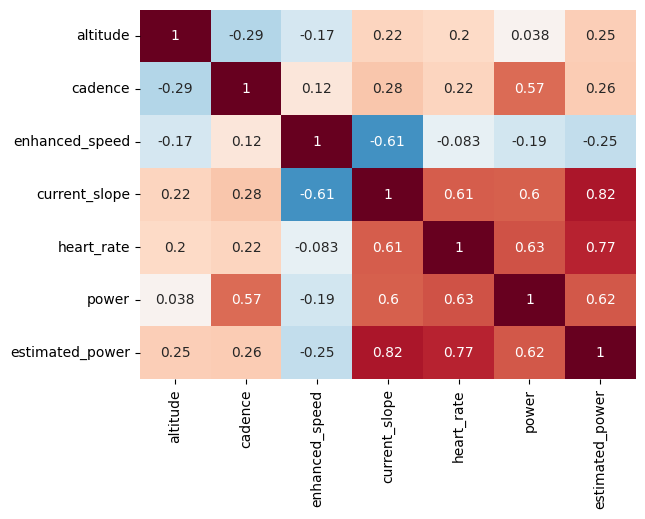

In [11]:
sns.heatmap(Xy.corr(), annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, cbar = False)

In [12]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression()

In [13]:
# Performance on training
print("R^2: {:.2f}".format(r2_score(y_train, ReLU(linreg.predict(X_train)))))
print("RMSE: {:.2f}".format(mean_squared_error(y_train, ReLU(linreg.predict(X_train)), squared=True)))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, ReLU(linreg.predict(X_train)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_train, ReLU(linreg.predict(X_train)))))
print()

# Performance on test
print("With ReLU")
print("\tR^2: {:.2f}".format(r2_score(y_test, ReLU(linreg.predict(X_test)))))
print("\tRMSE: {:.2f}".format(mean_squared_error(y_test, ReLU(linreg.predict(X_test)), squared=True)))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(linreg.predict(X_test)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(linreg.predict(X_test)))))
print()
print("Without ReLU")
print("\tR^2: {:.2f}".format(r2_score(y_test, linreg.predict(X_test))))
print("\tRMSE: {:.2f}".format(mean_squared_error(y_test, linreg.predict(X_test), squared=True)))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, linreg.predict(X_test))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, linreg.predict(X_test))))

R^2: 0.65
RMSE: 0.55
MAE: 0.50

With ReLU
	R^2: 0.66
	RMSE: 0.54
	MAE: 0.50

Without ReLU
	R^2: 0.65
	RMSE: 0.55
	MAE: 0.52


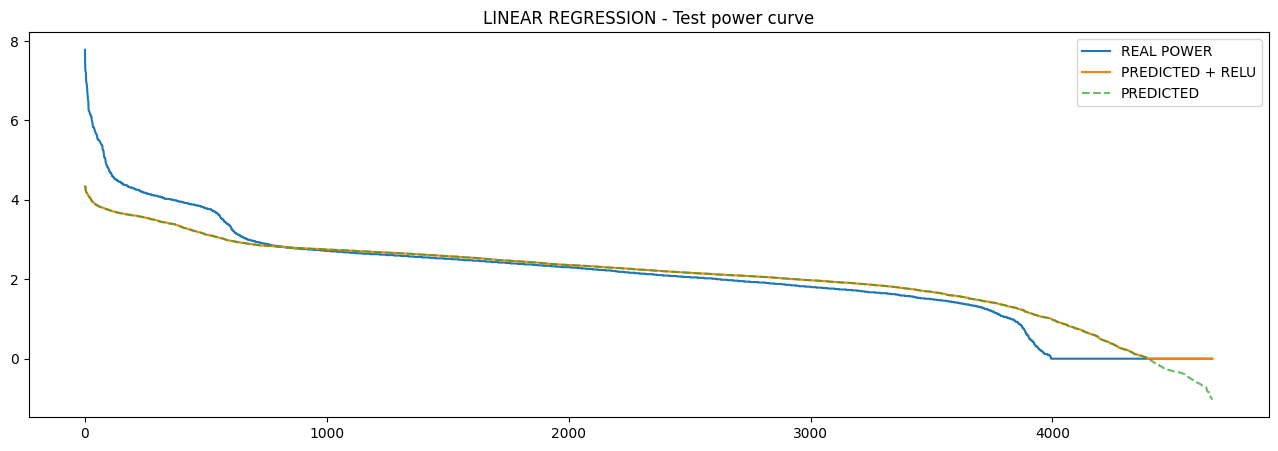

In [14]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER")
plt.plot(sorted(ReLU(linreg.predict(X_test)))[::-1], label = "PREDICTED + RELU")
plt.plot(sorted(linreg.predict(X_test))[::-1], label = "PREDICTED", alpha = .7, ls = "--")
plt.title("LINEAR REGRESSION - Test power curve")
plt.legend()
plt.show()

Tree Train RMSE: 0.0000



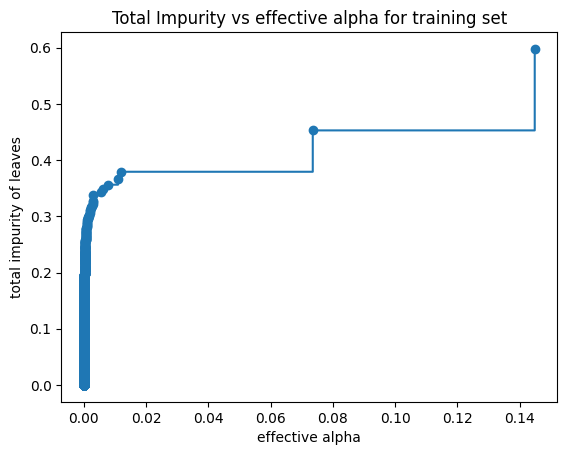

Fitting 3 folds for each of 5 candidates, totalling 15 fits
With ReLU
RMSE: 0.20
MAE: 0.24

Without ReLU
RMSE: 0.20
MAE: 0.24


In [15]:
# Initialize a Decision Tree Classifier

d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
d3.fit(X_train, y_train)
print("Tree Train RMSE: {:.4f}\n".format((mean_squared_error(y_train, d3.predict(X_train), squared=True))))

# Compute impurities to look for an adequate pruning term
path = d3.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot the impurity level given ccp_alpha
plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                     num = 5)]}

tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train, y_train)

# Show the results
print("With ReLU")
print("RMSE: {:.2f}".format(mean_squared_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)), squared=True)))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
print()
print("Without ReLU")
print("RMSE: {:.2f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test), squared=True)))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, tree_grid.best_estimator_.predict(X_test))))

In [19]:
X.head()

,altitude,cadence,enhanced_speed,current_slope,heart_rate,estimated_power
0,68.2,15.0,1.764,0.0,103.0,0.114995
1,68.2,15.0,1.764,0.0,103.0,0.083163
2,68.2,29.0,1.764,0.0,103.0,0.097061
3,68.2,29.0,1.764,0.0,103.0,0.103118
4,68.4,36.0,1.698,0.0,103.0,0.090055


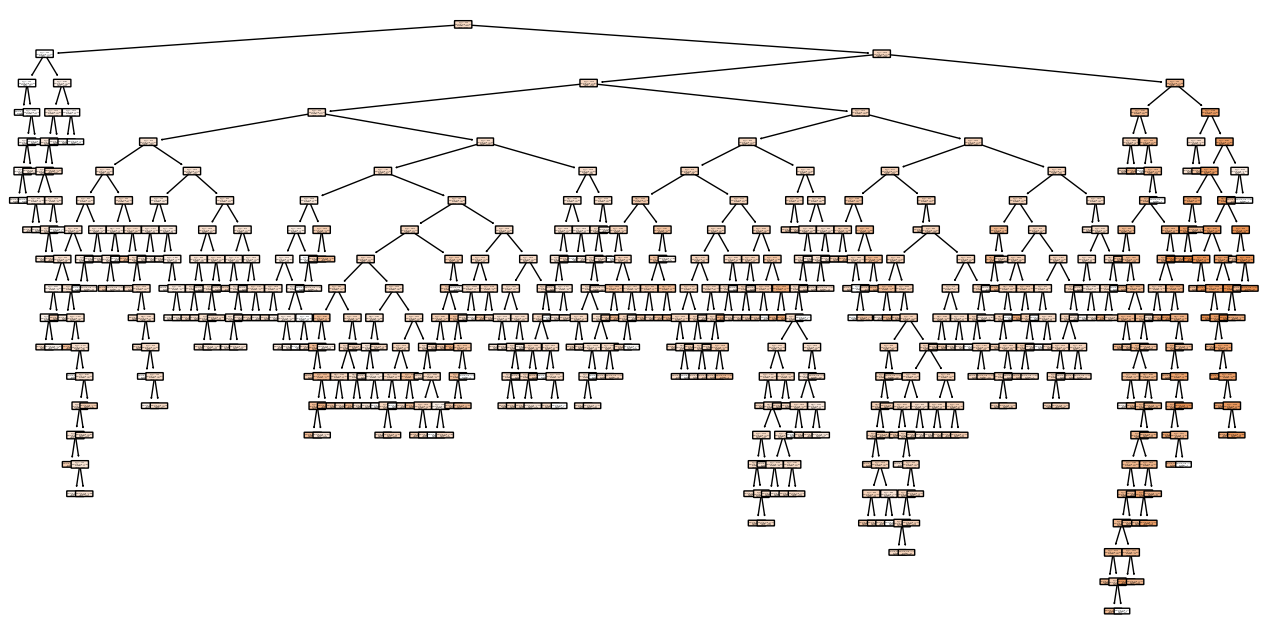

In [20]:
# tree.plot_tree(d3)
# plt.show()

fig_dpath, axes_dpath = plt.subplots(nrows = 1,ncols = 1,figsize = (16, 8))
tree.plot_tree(tree_grid.best_estimator_, filled = True, rounded = True, ax = axes_dpath)
plt.savefig('tree_grid_best_estimator_dpath.svg')#, dpi = 3000)

In [34]:
def predict_from_tree(tree, instance):
    node = 0  # start from the root
    while tree.children_left[node] != -1:  # while not a leaf
        feature_index = tree.feature[node]
        threshold = tree.threshold[node]
        
        if instance.iloc[feature_index] <= threshold:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    # When a leaf is reached
    return tree.value[node][0, 0]

# Example usage
instance = X.iloc[100]  # An instance to predict
prediction = predict_from_tree(tree_grid.best_estimator_.tree_, instance)
print(f"Predicted value: {prediction}")

Predicted value: 1.5555555555555556


In [63]:
import tree_estimator
tree_estimator.predict(*X.iloc[100].values.tolist())

In [70]:
###########################################
####### GET DATA COMPUTED BY STRAVA #######
###########################################

activities_df = pd.read_csv(os.getcwd() + "\\data\\activities.csv")
activities_df["Filename"] = activities_df["Filename"].apply(lambda v: v if pd.isnull(v)
                                                            else v.split("/")[1].replace(".gz", ""))

In [86]:
activities_df[activities_df["Filename"] == "12563553896.fit"]

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Private Note,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Average Flow,Flagged,Average Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
143,11778408976,"Jun 30, 2024, 9:16:20 AM",Tour De France Stage 2 🟡🟡,Ride,NaN,7058,22.58,187.0,67.0,False,NaN,Kross Vento 5.0,12563553896.fit,NaN,9.8,7058.0,5429.0,22586.560547,14.613281,4.160354,735.579956,363.0,59.400002,313.299988,28.646999,0.918688,NaN,NaN,108.0,62.618668,187.0,143.704071,NaN,123.103279,864.0,NaN,NaN,67.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0.0,98.0,0.0,NaN,1.0,NaN,1.719738e+09,1.0,28.389999,30.059999,19.33,0.58,1011.219971,3.92,8.11,231.0,0.0,1.719718e+09,1.719774e+09,0.875,11685373.0,NaN,0.52,5.0,0.02,25802.0,7.0,NaN,NaN,NaN,NaN,0.0,3.200136,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media/d0bbcad5-990f-4905-9254-f50bfbb4ea59.mp4...


In [73]:
_, test_data = parse_fit.get_dataframes(".\\data\\12563553896.fit")

In [96]:
test_data[["altitude", "enhanced_altitude"]].head()

,altitude,enhanced_altitude
0,77.8,77.8
1,77.4,77.4
2,76.4,76.4
3,75.6,75.6
4,74.6,74.6


In [92]:
test_prediction = []
for i in test_data.index:
    test_prediction += [tree_estimator.predict(test_data.loc[i, "enhanced_altitude"],
                                               test_data.loc[i, "cadence"],
                                               test_data.loc[i, "enhanced_speed"],
                                               test_data.loc[i, "current_slope"],
                                               test_data.loc[i, "heart_rate"],
                                               weight = 65,
                                               bike_wgt = 9.8)]

In [93]:
np.mean(np.array(test_prediction)*65)

119.05108945576428

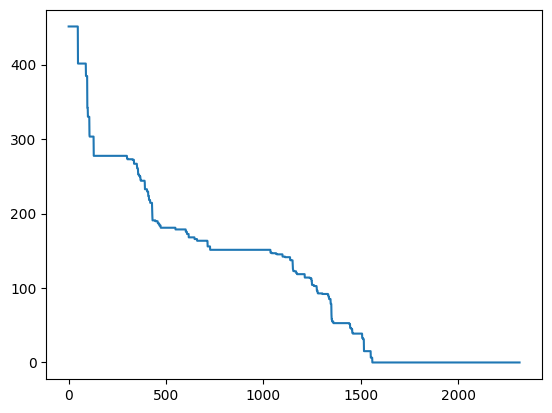

In [85]:
plt.plot(sorted(np.array(test_prediction)*65)[::-1])

In [72]:
activities_df.sample()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Private Note,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Average Flow,Flagged,Average Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
82,10549450845,"Jan 13, 2024, 10:47:02 AM",Zwift - Pacing #2 in Yorkshire,Virtual Ride,NaN,5710,30.02,165.0,45.0,False,NaN,Scott Addict RC (virtual),11287732963.fit,NaN,9.8,5710.0,4526.0,30019.0,21.950001,6.632567,517.0,0.0,97.0,182.600006,19.160074,-0.025317,NaN,NaN,105.0,85.20298,NaN,139.593414,NaN,123.948265,536.0,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,126.0,5065.0,0.0,119.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.257268,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media/72f54093-f791-416f-b873-f6a6adeae853.jpg


In [62]:
X.iloc[100]

altitude            68.800000
cadence             95.000000
enhanced_speed       7.063000
current_slope        0.032779
heart_rate         130.000000
estimated_power      1.583716
Name: 100, dtype: float64

In [32]:
X.head()

,altitude,cadence,enhanced_speed,current_slope,heart_rate,estimated_power
0,68.2,15.0,1.764,0.0,103.0,0.114995
1,68.2,15.0,1.764,0.0,103.0,0.083163
2,68.2,29.0,1.764,0.0,103.0,0.097061
3,68.2,29.0,1.764,0.0,103.0,0.103118
4,68.4,36.0,1.698,0.0,103.0,0.090055


In [27]:
(tree_grid.best_estimator_.tree_.children_right.shape,
 tree_grid.best_estimator_.tree_.children_left.shape, )

((615,), (615,))

In [24]:
tree_grid.best_estimator_.predict(pd.DataFrame(X.iloc[100]).T)

array([1.55555556])

In [25]:
y_test.shape, tree_grid.best_estimator_.predict(X_test).shape

((4662,), (4662,))

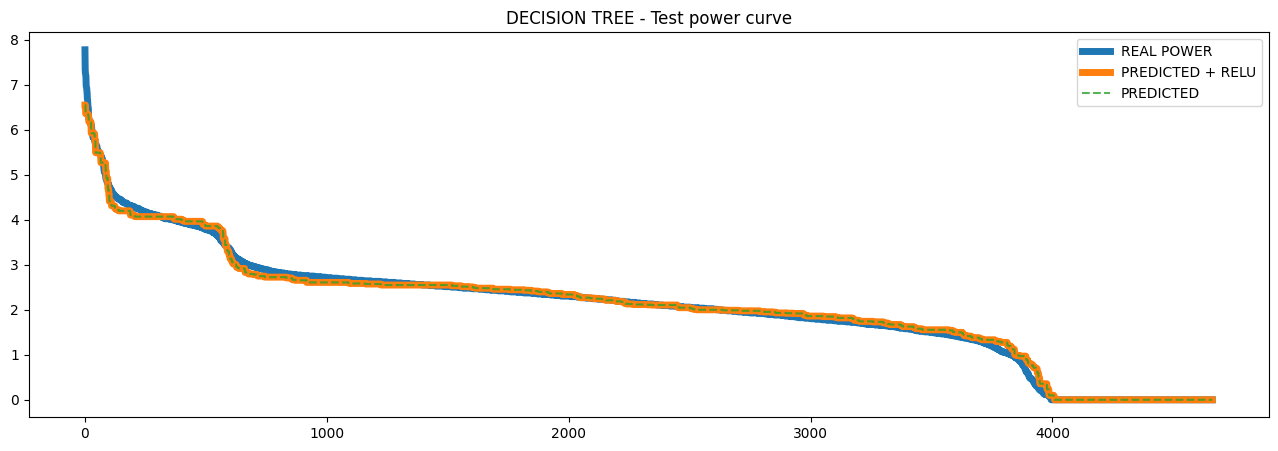

In [26]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
plt.plot(sorted(ReLU(tree_grid.best_estimator_.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
plt.plot(sorted(tree_grid.best_estimator_.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
plt.title("DECISION TREE - Test power curve")
plt.legend()
plt.show()

In [28]:
model = Sequential(name = "MLP")
model.add(Dense(input_dim = 6, units = 6, activation = "softplus", name = "dense_1"))
model.add(Dense(units = 50, activation = "softplus", name = "dense_2"))
model.add(Dense(units = 30, activation = "softplus", name = "dense_3"))
# model.add(Dense(units = 30, activation = "softplus", name = "dense_4"))
# model.add(Dense(units = 30, activation = "softplus", name = "dense_5"))
model.add(Dense(units = 1, activation = None, name = "dense_6"))
model.compile(loss = "mean_absolute_error", optimizer = "adam",
              metrics = ["mean_absolute_error"])
model.summary()

## Define an Early Stopping
early_stopping = EarlyStopping(monitor = "mean_absolute_error",
                               mode = "min", patience = 20, verbose = 1)

history = model.fit(X_train, y_train, epochs = 300, batch_size = 200,
                    verbose = 0, validation_split = 0.4, callbacks = [early_stopping])

c:\Users\ma.brocco\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953 (7.63 KB)

 Trainable params: 1,953 (7.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 118: early stopping


<Axes: >

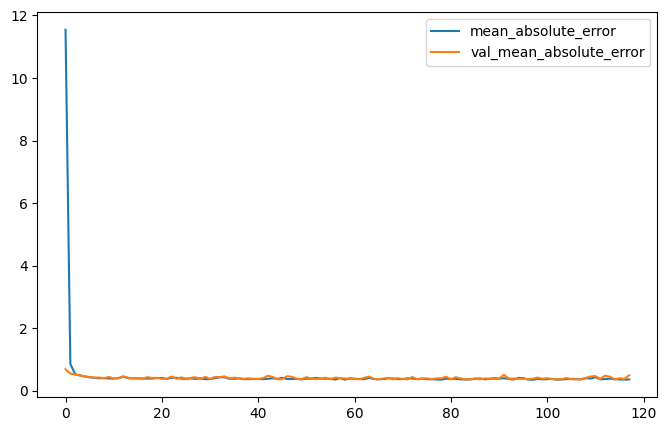

In [29]:
pd.DataFrame(history.history)[["mean_absolute_error", "val_mean_absolute_error"]].plot(figsize = (8, 5))

In [30]:
print("With ReLU")
print("\tRMSE: {:.2f}".format(mean_squared_error(y_test, ReLU(model.predict(X_test)), squared=True)))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(model.predict(X_test)))))
print("\tMAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(model.predict(X_test)))))
print()
print("Without ReLU")
print("\tRMSE: {:.2f}".format(mean_squared_error(y_test, model.predict(X_test), squared=True)))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
print("\tMAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, model.predict(X_test))))

With ReLU
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
	RMSE: 0.45
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
	MAE: 0.42
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
	MAPE: 11244462149562086.00 %

Without ReLU
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
	RMSE: 0.49
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
	MAE: 0.49
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
	MAPE: 39964411226863568.00 %


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


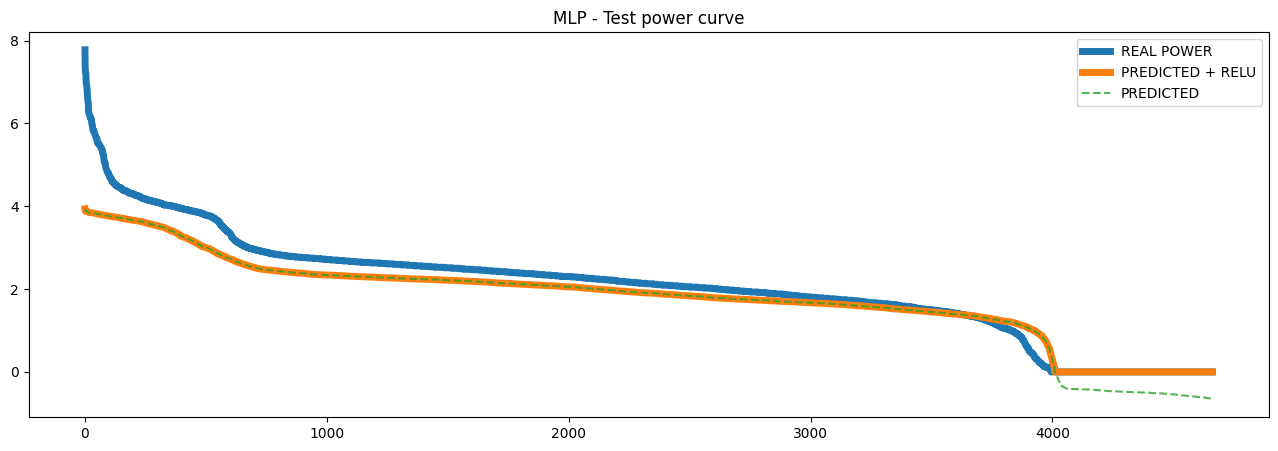

In [31]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
plt.plot(sorted(ReLU(model.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
plt.plot(sorted(model.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
# for ix in [50, 100, 150, 200, 250, 300]:
#     plt.axhline(ix, ls = "--", color = "grey", alpha = .5)
plt.title("MLP - Test power curve")
plt.legend()
plt.show()

In [ ]:
def relu(x):
    return np.maximum(0, x)
def sofplus(x):
    return np.log(np.exp(x) + 1)
def linear(x):
    return x

def predict_from_keras(weights, instance):
    output = instance
    for w, b in weights[:-1]:  # Apply all layers except the last
        output = relu(np.dot(output, w) + b)
    
    # Apply the last layer (assumed to be linear for regression)
    w, b = weights[-1]
    output = linear(np.dot(output, w) + b)
    
    return output[0]  # Since the output will be an array with one element

# Example usage
instance = X_test[0]  # An instance to predict
prediction = predict_from_keras(weights, instance)
print(f"Predicted value: {prediction}")